# Введение: Автоматическая оптимизация гиперпараметров

В этом ноутбуке е мы рассмотрим автоматическую настройку гиперпараметров с помощью байесовской оптимизации. В частности, мы оптимизируем гиперпараметры Gradient Boosting Machine, используя библиотеку Hyperopt (с алгоритмом оценки Tree Parzen Estimator). Мы сравним результаты случайного поиска (реализованного вручную) для настройки гиперпараметров с методом оптимизации основанной на байесовской модели, чтобы попытаться понять, как работает байесовский метод и какие преимущества он имеет по сравнению со случайными методами поиска.

## Hyperopt

Hyperopt - одна из нескольких библиотек автоматического подбора гиперпараметров, использующих байесовскую оптимизацию. Эти библиотеки различаются по алгоритму, используемому как для создания surrogate (вероятностной модели) целевой функции, так и для выбора следующих гиперпараметров для оценки в целевой функции. Hyperopt использует Tree Parzen Estimator (TPE). Другие библиотеки Python включают Spearmint, который использует гауссовский процесс для surrogate, и SMAC, который использует регрессию случайного леса.

Hyperopt имеет простой синтаксис для структурирования задачи оптимизации, распространяющийся на настройку гиперпараметров для любой проблемы, включающей в себя минимизацию функции. Более того, структура задачи байесовской оптимизации одинакова во всех библиотеках, с основными различиями в синтаксисе (и в алгоритмах под капотом, с которыми мы не будем иметь дело).

In [1]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# Modeling
import lightgbm as lgb

# Evaluation of the model
from sklearn.model_selection import KFold

MAX_EVALS = 500
N_FOLDS = 10

/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


## Данные

В этом ноутбуке мы будем работать с датасетом Caravan Insurance Challenge  [взятым с Kaggle](https://www.kaggle.com/uciml/caravan-insurance-challenge). Обучая модель на прошлых данных, нужно определить, будет ли потенциальный клиент покупать страховой полис. Это простая задача классификации машинного обучения с учителем: мы хотим обучить модель на прошлых данных, для прогнозирования бинарного результата на тестовых данных.

In [22]:
# Read in data and separate into training and testing sets
data = pd.read_csv('data/caravan-insurance-challenge.csv')
train = data[data['ORIGIN'] == 'train']
test = data[data['ORIGIN'] == 'test']

# Extract the labels and format properly
train_labels = np.array(train['CARAVAN'].astype(np.int32)).reshape((-1,))
test_labels = np.array(test['CARAVAN'].astype(np.int32)).reshape((-1,))

# Drop the unneeded columns
train = train.drop(columns = ['ORIGIN', 'CARAVAN'])
test = test.drop(columns = ['ORIGIN', 'CARAVAN'])

# Convert to numpy array for splitting in cross validation
features = np.array(train)
test_features = np.array(test)
labels = train_labels[:]

print('Train shape: ', train.shape)
print('Test shape: ', test.shape)
train.head()

Train shape:  (5822, 85)
Test shape:  (4000, 85)


,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,...,ALEVEN,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND
0,33,1,3,2,8,0,5,1,3,7,...,0,0,0,0,1,0,0,0,0,0
1,37,1,2,2,8,1,4,1,4,6,...,0,0,0,0,1,0,0,0,0,0
2,37,1,2,2,8,0,4,2,4,3,...,0,0,0,0,1,0,0,0,0,0
3,9,1,3,3,3,2,3,2,4,5,...,0,0,0,0,1,0,0,0,0,0
4,40,1,4,2,10,1,4,1,4,7,...,0,0,0,0,1,0,0,0,0,0


#### Распределение меток

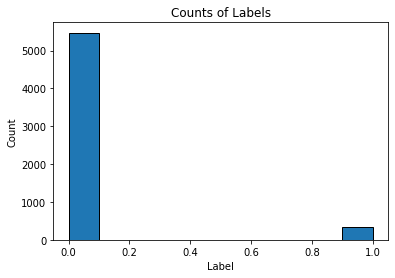

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

plt.hist(labels, edgecolor = 'k'); 
plt.xlabel('Label'); plt.ylabel('Count'); plt.title('Counts of Labels');

Это задача с несбалансированными классами: гораздо больше наблюдений, когда страховой полис не был куплен (0), чем когда он был куплен (1). Следовательно, точность - плохая метрика для этой задачи. Вместо этого мы будем использовать обычную кассификационную метрику ROC AUC. Случайное угадывание в задаче классификации даст ROC AUC 0.5, а идеальный классификатор даст ROC AUC 1.0. Для лучшей базовой модели, чем случайное угадывание, мы можем обучить Gradient Boosting Machine по умолчанию и делать прогнозы с ее помощью.

### Модель по умолчанию Gradient Boosting Machine

Мы будем использовать LightGBM-реализацию gradient boosting machine. Это намного быстрее, чем реализация Scikit-Learn, и дает результаты, сравнимые с extreme gradient boosting, XGBoost. Для базовой модели мы будем использовать гиперпараметры по умолчанию,  указанные в LightGBM.

In [24]:
# Model with default hyperparameters
model = lgb.LGBMClassifier()
model

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

Все, что нам нужно сделать, это обучить модель на тренировочных данных и сделать прогнозы на тестовых. Поскольку мы измеряем ROC AUC, а не точность, мы будем использовать для прогнозов предсказанные моделью вероятности, а не жесткие двоичные значения.

In [25]:
from sklearn.metrics import roc_auc_score
from timeit import default_timer as timer

start = timer()
model.fit(features, labels)
train_time = timer() - start

predictions = model.predict_proba(test_features)[:, 1]
auc = roc_auc_score(test_labels, predictions)

print('Результат базовой модели на тестовых данных равен {:.4f}.'.format(auc))
print('Время обучения тестовой модели равно {:.4f} секунды'.format(train_time))


Результат базовой модели на тестовых данных равен 0.7092.
Время обучения тестовой модели равно 0.2011 секунды


Это метрики которые нам нужно улучшить. Из-за небольшого размера набора данных (менее 6000 наблюдений) настройка гиперпараметров окажет умеренное, но заметное влияние на качество модели (большего эффекта можно добиться собрав больше данных!)

# Случайный поиск

Сначала мы реализуем обычный метод оптимизации гиперпараметров: случайный поиск. На каждой итерации мы выбираем случайный набор гиперпараметров модели из пространства поиска. Эмпирически случайный поиск очень эффективен, он дает близкие к поиску по сетке результаты, при этом значительно сокращая время, затрачиваемое на поиск. Однако это все еще неинформированный метод в том смысле, что он не использует прошлые оценки целевой функции для информирования при выборе, который он делает для следующей оценки.

Случайный поиск состоит из следующих четырех частей, которые также используются в байесовской оптимизации гиперпараметров:

1. Область определения: диапазоны значений в которых происходит поиск
2. Алгоритм оптимизации: случайно выбираем следующее значение! (да это квалифицируется как алгоритм)
3. Минимизируемая целевая функция: в нашем случае это кросс валидация ROC AUC
4. История результатов которая отслеживает попытки выбора гиперпараметров и кросс-валидационную метрику.

Случайный поиск может быть реализован в библиотеке Scikit-Learn с использованием `RandomizedSearchCV`, однако, поскольку мы используем раннюю остановку (для определения оптимального числа оценщиков), мы реализуем этот метод самостоятельно (больше практики!). Это довольно просто, и многие идеи случайного поиска будут использованы в байесовской оптимизации гиперпараметров. 

In [6]:
import random

## Область определения для случайного поиска

И случайный поиск и байесовкая опимизация ищут гиперпараметры в некоторой области. Для случайного (или поиска по сетке) эта область называется сетка гиперпараметров и использует дискретные значения для гиперпараметров.

Сперва взглянем на все гиперпараметры которые нужно настроить.

In [26]:
lgb.LGBMClassifier()

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

На основе значений по умолчанию мы можем построить следующую сетку гиперпараметров. Сложно сказать заранее, какой выбор будет работать лучше, поэтому мы будем использовать широкий диапазон значений центрированный относительно значения по умолчанию для большинства гиперпараметров.

`subsample_dist` будет использован для `subsample` параметра, но мы не можем добавить его в сетку параметров поскольку `boosting_type=goss` не поддерживает подвыборку строк. Поэтому мы будем использовать оператор `if` при выборе наших гиперпараметров, чтобы выбрать пропорцию подвыборки если тип бустинга не  `goss`.

In [8]:
# Hyperparameter grid
param_grid = {
    'class_weight': [None, 'balanced'],
    'boosting_type': ['gbdt', 'goss', 'dart'],
    'num_leaves': list(range(30, 150)),
    'learning_rate': list(np.logspace(np.log(0.005), np.log(0.2), base = np.exp(1), num = 1000)),
    'subsample_for_bin': list(range(20000, 300000, 20000)),
    'min_child_samples': list(range(20, 500, 5)),
    'reg_alpha': list(np.linspace(0, 1)),
    'reg_lambda': list(np.linspace(0, 1)),
    'colsample_bytree': list(np.linspace(0.6, 1, 10))
}

# Subsampling (only applicable with 'goss')
subsample_dist = list(np.linspace(0.5, 1, 100))

Давайте рассмотрим два распределения: learning_rate и num_leaves. Скорость обучения обычно [представлена логарифмическим распределением](https://www.quora.com/Why-does-one-sample-the-log-space-when-searching-for-good-Hyper-Parameters-for-Machine-Learning), поскольку она может варьироваться в пределах нескольких порядков. np.logspace возвращает значения, равномерно распределенные по логарифмической шкале (поэтому, если мы возьмем логарифм результатов, распределение будет равномерным).

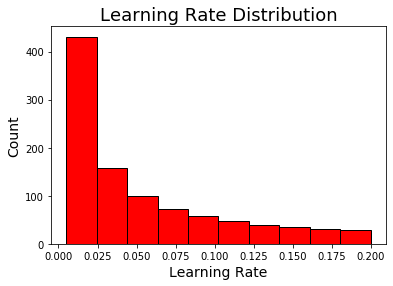

In [27]:
plt.hist(param_grid['learning_rate'], color = 'r', edgecolor = 'k');
plt.xlabel('Learning Rate', size = 14); plt.ylabel('Count', size = 14); plt.title('Learning Rate Distribution', size = 18);

Меньшие значения скорости обучения чаще встречаются со значениями от 0,005 до 0,2. Диапазон области довольно велик, что указывает на большую неопределенность с нашей стороны относительно оптимального значения (которое, мы надеемся, находится где-то в сетке)!

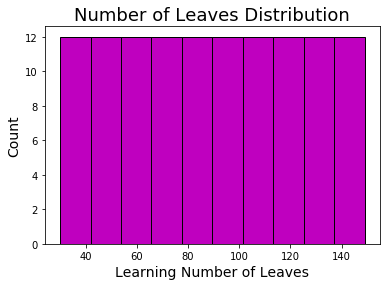

In [28]:
plt.hist(param_grid['num_leaves'], color = 'm', edgecolor = 'k')
plt.xlabel('Learning Number of Leaves', size = 14); plt.ylabel('Count', size = 14); plt.title('Number of Leaves Distribution', size = 18);

Количество листьев это обычная равномерная область

### Выборка из области определения гиперпараметра

Посмотрим как мы делаем выборку из множества гиперпараметров из нашей сетки используя понимание словаря (dictionary comprehension).

In [29]:
# Randomly sample parameters for gbm
params = {key: random.sample(value, 1)[0] for key, value in param_grid.items()}
params

{'class_weight': None,
 'boosting_type': 'dart',
 'num_leaves': 35,
 'learning_rate': 0.015082225756147042,
 'subsample_for_bin': 60000,
 'min_child_samples': 285,
 'reg_alpha': 0.7346938775510203,
 'reg_lambda': 0.2040816326530612,
 'colsample_bytree': 0.6}

Чтобы добавить долю `subsample` если `boosting_type` не `goss`, мы можем использовать оператор if.

In [30]:
params['subsample'] = random.sample(subsample_dist, 1)[0] if params['boosting_type'] != 'goss' else 1.0
params

{'class_weight': None,
 'boosting_type': 'dart',
 'num_leaves': 35,
 'learning_rate': 0.015082225756147042,
 'subsample_for_bin': 60000,
 'min_child_samples': 285,
 'reg_alpha': 0.7346938775510203,
 'reg_lambda': 0.2040816326530612,
 'colsample_bytree': 0.6,
 'subsample': 0.6666666666666667}

Мы установим значение subsample равным 1.0 если вид бустинга - goss что значит что мы не используем подвыборки. (При использовании подвыборки мы обучаемся на подмножестве строк (наблюдений) а не на всем множестве данных. Эта техника также называется bagging для "bootstrap aggregating").

## Кросс-валидация с ранней остановкой в LightGBM

Кросс-валидация api scikit-learn не имеет опцию ранней остановки. Поэтому мы будем использовать функцию кросс-валидации LightGBM с 100 раундов ранней остановки. Для использования этой функции нам нужно создать датасет из наших признаков и меток.

In [31]:
# Создание lgb датасета
train_set = lgb.Dataset(features, label = labels)

Функция `cv` принимает параметры, обучающие данные, количество раундов обучения, количество фолдов, метрику, количество ранних остановок и несколько других аргументов. Мы установили количество раундов бустинга очень высоким, но на самом деле мы не будем обучать так много оценщиков, потому что мы используем раннюю остановку и прекращаем обучение, когда оценка валидации не улучшилась для 100 оценщиков.

In [32]:
# Выполняет кросс-валидацию с 10 фолдами
r = lgb.cv(params, train_set, num_boost_round = 10000, nfold = 10, metrics = 'auc', 
           early_stopping_rounds = 100, verbose_eval = False, seed = 50)

# Наибольший результат
r_best = np.max(r['auc-mean'])

# Стандартное отклонение наилучего результата
r_best_std = r['auc-stdv'][np.argmax(r['auc-mean'])]

print('Максимальный ROC AUC на проверочных данных был {:.5f} с std равным {:.5f}.'.format(r_best, r_best_std))
print('Идеальное число итераций было {}.'.format(np.argmax(r['auc-mean']) + 1))

Максимальный ROC AUC на проверочных данных был 0.76462 с std равным 0.03837.
Идеальное число итераций было 309.


### Датафрейм результатов

У нас есть наши область и алгоритм, который в данном случае является случайным выбором. Две другие части, которые нам нужны для задачи оптимизации, - это целевая функция и структура данных для отслеживания результатов (эти же четыре части потребуются при байесовской оптимизации).

Отслеживание результатов будет осуществляться в `dataframe`, где в каждой строке будет храниться одна оценка целевой функции.

In [33]:
# Dataframe to hold cv results
random_results = pd.DataFrame(columns = ['loss', 'params', 'iteration', 'estimators', 'time'],
                       index = list(range(MAX_EVALS)))

### Целевая функция

Целевая функция примет гиперпараметры и вернет потери на проверочных данных (вместе с некоторой другой информацией для отслеживания прогресса поиска). Мы уже выбрали в качестве метрики ROC AUC, и теперь нам нужно выяснить, как его измерить. Мы не можем оценить ROC AUC на тестовом наборе, потому что это будет обманом. Вместо этого мы должны использовать проверочный набор данных для настройки модели и надеяться, что результаты распространятся и на тестовое множество.

Вместо выделения проверочных данных из обучающей выборки (что ограничивает количество имеющихся у нас данных обучения), лучше использовать перекрестную проверку KFold. Помимо того что мы не уменьшаем обучающие данные, этот метод должен также дать нам лучшую оценку ошибки обобщения на тестовые данные, потому что мы будем использовать K проверок, а не только одну. В этом примере мы будем использовать 10-фолдовую кросс-валидацию, что означает тестирование и обучение каждого набора гиперпараметров модели 10 раз, каждый раз используя различные подмножества обучающих данных в качестве проверочной выборки. Целевая функция вернет список информации, включая валидационный AUC ROC. Мы также хотим сохранить используемые гиперпараметры, чтобы мы знали, какие из них являются оптимальными (или лучшими из тех, что мы пробовали).

В случае случайного поиска следующие выбранные значения не зависят от результатов прошлой оценки, но мы должны четко отслеживать их, чтобы знать, какие значения сработали лучше всего! Это также позволит нам сопоставить случайный поиск с информированной байесовской оптимизацией.

In [34]:
def random_objective(params, iteration, n_folds = N_FOLDS):
    """Random search objective function. Takes in hyperparameters
       and returns a list of results to be saved."""

    start = timer()
    
    # Выполняет n_folds кросс-валидацию
    cv_results = lgb.cv(params, train_set, num_boost_round = 10000, nfold = n_folds, 
                        early_stopping_rounds = 100, metrics = 'auc', seed = 50)
    end = timer()
    best_score = np.max(cv_results['auc-mean'])
    
    # Потери должны быть минимизированы
    loss = 1 - best_score
    
    # Раунды бустинга возвращающие наибольший cv score
    n_estimators = int(np.argmax(cv_results['auc-mean']) + 1)
    
    # Возвращение списка результатов
    return [loss, params, iteration, n_estimators, end - start]

## Имплементация случайного поиска

Теперь мы можем написать цикл для итерации по количеству оценок, каждый раз выбирая для оценки различный набор гиперпараметров. При каждом прохождении функции результаты сохраняются в датафрейм. (Магия `%% capture` перехватывает любые выходные данные из ячейки в блокноте Jupyter. Это полезно, потому что выходные данные обучающего прогона LightGBM не могут быть заглушены).


In [36]:
%%capture

random.seed(50)

# Iterate through the specified number of evaluations
for i in range(MAX_EVALS):
    
    # Randomly sample parameters for gbm
    params = {key: random.sample(value, 1)[0] for key, value in param_grid.items()}
    
    print(params)
    
    if params['boosting_type'] == 'goss':
        # Cannot subsample with goss
        params['subsample'] = 1.0
    else:
        # Subsample supported for gdbt and dart
        params['subsample'] = random.sample(subsample_dist, 1)[0]
        
        
    results_list = random_objective(params, i)
    
    # Add results to next row in dataframe
    random_results.loc[i, :] = results_list

{'class_weight': 'balanced', 'boosting_type': 'goss', 'num_leaves': 76, 'learning_rate': 0.055533968216953146, 'subsample_for_bin': 80000, 'min_child_samples': 460, 'reg_alpha': 0.6122448979591836, 'reg_lambda': 1.0, 'colsample_bytree': 0.8222222222222222}
{'class_weight': None, 'boosting_type': 'dart', 'num_leaves': 70, 'learning_rate': 0.011646863384981408, 'subsample_for_bin': 220000, 'min_child_samples': 375, 'reg_alpha': 0.1020408163265306, 'reg_lambda': 0.18367346938775508, 'colsample_bytree': 0.8222222222222222}
{'class_weight': 'balanced', 'boosting_type': 'goss', 'num_leaves': 58, 'learning_rate': 0.010197109660117238, 'subsample_for_bin': 40000, 'min_child_samples': 230, 'reg_alpha': 0.7755102040816326, 'reg_lambda': 0.7755102040816326, 'colsample_bytree': 0.8666666666666667}
{'class_weight': None, 'boosting_type': 'gbdt', 'num_leaves': 118, 'learning_rate': 0.048981732603349946, 'subsample_for_bin': 280000, 'min_child_samples': 230, 'reg_alpha': 0.8979591836734693, 'reg_lamb

KeyboardInterrupt: 

In [18]:
# Sort results by best validation score
random_results.sort_values('loss', ascending = True, inplace = True)
random_results.reset_index(inplace = True, drop = True)
random_results.head()

,loss,params,iteration,estimators,time
0,0.232707,"{'class_weight': 'balanced', 'boosting_type': ...",292,161,5.35296
1,0.233449,"{'class_weight': None, 'boosting_type': 'dart'...",134,166,5.02008
2,0.234382,"{'class_weight': None, 'boosting_type': 'gbdt'...",369,295,5.29839
3,0.23443,"{'class_weight': None, 'boosting_type': 'gbdt'...",146,455,7.01225
4,0.234836,"{'class_weight': 'balanced', 'boosting_type': ...",284,115,4.52999


### Эффективность случайного поиска

Напомним, что базовая модель градиентного бустинга достигла результата 0.71 на тренировочных данных. Мы можем использовать лучшие параметры для случайного поиска и оценить их на тестовом множестве. 

Чему равны гиперпараметры вернувшие наибольший результат на целевой функции??

In [37]:
random_results.loc[0, 'params']

{'class_weight': 'balanced',
 'boosting_type': 'goss',
 'num_leaves': 76,
 'learning_rate': 0.055533968216953146,
 'subsample_for_bin': 80000,
 'min_child_samples': 460,
 'reg_alpha': 0.6122448979591836,
 'reg_lambda': 1.0,
 'colsample_bytree': 0.8222222222222222,
 'subsample': 1.0}

Ключ `estimators` содержит среднеее число оценщиков обученных с ранней остановкой (усредненные относительно 10 фолдов). Мы можем использовать это как оптимальное число оценщиков в модели градиентного бустинга.

In [41]:
# Найдем лучшие параметры и число оценщиков
best_random_params = random_results.loc[0, 'params'].copy()
best_random_estimators = int(random_results.loc[0, 'estimators'])
best_random_model = lgb.LGBMClassifier(n_estimators=best_random_estimators, n_jobs = -1, 
                                       objective = 'binary', **best_random_params, random_state = 50)

# Обучимся на тренировочных данных
best_random_model.fit(features, labels)

# Сделаем предсказания на тестовых данных
predictions = best_random_model.predict_proba(test_features)[:, 1]


print('Лучшая модель из результатов случайного поиска на тестовых данных {:.4f}.'.format(roc_auc_score(test_labels, predictions)))
print('Это было достигнуто используя {} поисковых итераций.'.format(random_results.loc[0, 'iteration']))

Лучшая модель из результатов случайного поиска на тестовых данных 0.7108.
Это было достигнуто используя 0 поисковых итераций.


Скромное улучшение по сравнению с базовым уровнем. Использование большего количества оценок может увеличить результат, но за счет увеличения времени оптимизации. Мы также должны помнить, что гиперпараметры оптимизированы на проверочных данных, что может не сработать на тестовых.

Сейчас мы можем перейти к байесовским методам и посмотреть можно ли на них получить лучшие результаты.

# Байесовская оптимизация гиперпараметров с использованием Hyperopt

Для байесовской оптимизации нам нужны следующие 4 пункта:

1. Целевая функция
2. Пространство определения значений
3. Алгоритм оптимизации гиперпараметров
4. История результатов

Мы уже использовали все это в случайном поиске, но для Hyperopt мы сделаем несколько изменений

## Целевая функция

Эта целевая функция все еще принимает на вход гиперпараметры, но она возвращает не список, а словарь. Единственное требование для целевой функции в Hyperopt это то, что она должна иметь в возвращаемом словаре ключ `"loss"`  для минимизации и ключ называемый `"status"` указывающий на то, что выполнение было успешно.

Если мы хотим отслеживать число итераций, мы можем объявить глобальную переменную `ITERATION` которая увеличивается при каждом вызове функции. Кроме того для получения подробных результатов, каждый раз когда выполняется функция, мы будем писать результаты в новую строку csv файла. Это может быть полезно для очень долгих вычислений, если мы хотим проверять прогресс (это может быть не самое элегантное решение, но оно лучше чем выводить результаты в консоль, поскольку в нашем случае мы их сохраняем!) 

Наиболее важной частью этой функции является то, что нам сейчас нужно вернуть __value to minimize__ а не сырой ROC AUC. Мы пытаемся найти лучшее значение целевой функции, и хоть больший ROC AUC лучше, Hyperopt может только минимизировать функцию. Поэтому простое решение - возвращать 1 - ROC (мы делали это и для случайного поиска в качестве практики).

In [43]:
import csv
from hyperopt import STATUS_OK
from timeit import default_timer as timer

def objective(params, n_folds = N_FOLDS):
    """Целевая функция для оптимизации гиперпараметров Gradient Boosting Machine"""
    
    # Keep track of evals
    global ITERATION
    
    ITERATION += 1
    
    # Получение подвыборки если небоходимо, иначе установка 1.0
    subsample = params['boosting_type'].get('subsample', 1.0)
    
    # Получение типа бустинга
    params['boosting_type'] = params['boosting_type']['boosting_type']
    params['subsample'] = subsample
    
    # Убедимся что параметры которые должны быть целочисленны - целочисленны
    for parameter_name in ['num_leaves', 'subsample_for_bin', 'min_child_samples']:
        params[parameter_name] = int(params[parameter_name])
    
    start = timer()
    
    # Выполним n_folds кросс-валидацию
    cv_results = lgb.cv(params, train_set, num_boost_round = 10000, nfold = n_folds, 
                        early_stopping_rounds = 100, metrics = 'auc', seed = 50)
    
    run_time = timer() - start
    
    # Получим лучший результат
    best_score = np.max(cv_results['auc-mean'])
    
    # Потери должны быть минимизированы
    loss = 1 - best_score
    
    # Раунды бустинга возвращающие наибольший cv score
    n_estimators = int(np.argmax(cv_results['auc-mean']) + 1)

    # Запишем в csv ('a' значит append)
    of_connection = open(out_file, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([loss, params, ITERATION, n_estimators, run_time])
    
    # Словарь с информацией для выполнения
    return {'loss': loss, 'params': params, 'iteration': ITERATION,
            'estimators': n_estimators, 
            'train_time': run_time, 'status': STATUS_OK}

Хотя Hyperopt-у нужен только `loss`, хорошо бы отслеживать и другие метрики, чтобы мы могли проверить результаты. Позже мы можем сравнить последовательности поисков с двух подходов, что поможет нам понять как работает метод. 

## Domain Space

Specifying the domain (called the `space` in Hyperopt) is a little trickier than in grid search. In Hyperopt, and other Bayesian optimization frameworks, the domian is not a discrete grid but instead has probability distributions for each hyperparameter. For each hyperparameter, we will use the same limits as with the grid, but instead of being defined at each point, the domain represents probabilities for each hyperparameter. This will probably become clearer in the code and the images! 

In [ ]:
from hyperopt import hp
from hyperopt.pyll.stochastic import sample

First we will go through an example of the learning rate. Again, we are using a log-uniform space for the learning rate defined from 0.005 to 0.2 (same as with the grid from random search.) This time, when we graph the domain, it's more accurate to see a kernel density estimate plot than a histogram (although both show distributions). 

In [ ]:
# Create the learning rate
learning_rate = {'learning_rate': hp.loguniform('learning_rate', np.log(0.005), np.log(0.2))}

We can visualize the learning rate by sampling from the space using a Hyperopt utility. Here we plot 10000 samples.

In [ ]:
learning_rate_dist = []

# Draw 10000 samples from the learning rate domain
for _ in range(10000):
    learning_rate_dist.append(sample(learning_rate)['learning_rate'])
    
plt.figure(figsize = (8, 6))
sns.kdeplot(learning_rate_dist, color = 'red', linewidth = 2, shade = True);
plt.title('Learning Rate Distribution', size = 18); 
plt.xlabel('Learning Rate', size = 16); plt.ylabel('Density', size = 16);

The number of leaves is again a uniform distribution. Here we used `quniform` which means a discrete uniform (as opposed to continuous).

In [ ]:
# Discrete uniform distribution
num_leaves = {'num_leaves': hp.quniform('num_leaves', 30, 150, 1)}
num_leaves_dist = []

# Sample 10000 times from the number of leaves distribution
for _ in range(10000):
    num_leaves_dist.append(sample(num_leaves)['num_leaves'])
    
# kdeplot
plt.figure(figsize = (8, 6))
sns.kdeplot(num_leaves_dist, linewidth = 2, shade = True);
plt.title('Number of Leaves Distribution', size = 18); plt.xlabel('Number of Leaves', size = 16); plt.ylabel('Density', size = 16);

### Conditional Domain

In Hyperopt, we can use nested conditional statements to indicate hyperparameters that depend on other hyperparameters. For example, we know that `goss` boosting type cannot use subsample, so when we set up the `boosting_type` categorical variable, we have to se the `subsample` to 1.0 while for the other boosting types it's a float between 0.5 and 1.0 Let's see this with an example:

In [ ]:
# boosting type domain 
boosting_type = {'boosting_type': hp.choice('boosting_type', 
                                            [{'boosting_type': 'gbdt', 'subsample': hp.uniform('subsample', 0.5, 1)}, 
                                             {'boosting_type': 'dart', 'subsample': hp.uniform('subsample', 0.5, 1)},
                                             {'boosting_type': 'goss', 'subsample': 1.0}])}

# Draw a sample
params = sample(boosting_type)
params

We need to set both the `boosting_type` and `subsample` as top-level keys in the parameter dictionary. We can use the Python `dict.get` method with a default value of 1.0. This means that if the key is not present in the dictionary, the value returned will be the default (1.0).

In [ ]:
# Retrieve the subsample if present otherwise set to 1.0
subsample = params['boosting_type'].get('subsample', 1.0)

# Extract the boosting type
params['boosting_type'] = params['boosting_type']['boosting_type']
params['subsample'] = subsample

params

This is because the gbm cannot use the nested dictionary so we need to set the `boosting_type` and `subsample` as top level keys. Nested conditionals allow us to use a different set of hyperparameters depending on other hyperparameters. For example, we can explore different models with completely different sets of hyperparameters by using nested conditionals. The only requirement is that the first nested statement must be based on a `choice` hyperparameter (the choice could be the type of model).

## Complete Bayesian Domain

Now we can define the entire domain. Each variable needs to have a label and a few parameters specifying the type and extent of the distribution. For the variables such as boosting type that are categorical, we use the `choice` variable. Other variables types include `quniform`, `loguniform`, and `uniform`. For the complete list, check out the [documentation](https://github.com/hyperopt/hyperopt/wiki/FMin) for Hyperopt. 

In [ ]:
# Define the search space
space = {
    'class_weight': hp.choice('class_weight', [None, 'balanced']),
    'boosting_type': hp.choice('boosting_type', [{'boosting_type': 'gbdt', 'subsample': hp.uniform('gdbt_subsample', 0.5, 1)}, 
                                                 {'boosting_type': 'dart', 'subsample': hp.uniform('dart_subsample', 0.5, 1)},
                                                 {'boosting_type': 'goss', 'subsample': 1.0}]),
    'num_leaves': hp.quniform('num_leaves', 30, 150, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'subsample_for_bin': hp.quniform('subsample_for_bin', 20000, 300000, 20000),
    'min_child_samples': hp.quniform('min_child_samples', 20, 500, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0)
}

### Example of Sampling from the Domain 

Let's sample from the domain (using the conditional logic) to see the result of each draw. Every time we run this code, the results will change. (Again notice that we need to assign the top level keys to the keywords understood by the GBM).

In [ ]:
# Sample from the full space
x = sample(space)

# Conditional logic to assign top-level keys
subsample = x['boosting_type'].get('subsample', 1.0)
x['boosting_type'] = x['boosting_type']['boosting_type']
x['subsample'] = subsample

x

In [ ]:
x = sample(space)
subsample = x['boosting_type'].get('subsample', 1.0)
x['boosting_type'] = x['boosting_type']['boosting_type']
x['subsample'] = subsample
x

## Optimization Algorithm

Although this is the most technical part of Bayesian optimization, defining the algorithm to use in Hyperopt is simple. We will use the Tree Parzen Estimator (read about it [in this paper](https://papers.nips.cc/paper/4443-algorithms-for-hyper-parameter-optimization.pdf)) which is one method for constructing the surrogate function and choosing the next hyperparameters to evaluate. 

In [ ]:
from hyperopt import tpe

# optimization algorithm
tpe_algorithm = tpe.suggest

## Results History

The final part is the result history. Here, we are using two methods to make sure we capture all the results:

1. A `Trials` object that stores the dictionary returned from the objective function
2. Writing to a csv file every iteration

The csv file option also lets us monitor the results of an on-going experiment. (Although do not use Excel to open the file while training is on-going. Instead check the results using `tail results/gbm_trials.csv` from bash or another command line.

In [ ]:
from hyperopt import Trials

# Keep track of results
bayes_trials = Trials()

The `Trials` object will hold everything returned from the objective function in the `.results` attribute. It also holds other information from the search, but we return everything we need from the objective. 

In [ ]:
# File to save first results
out_file = 'results/gbm_trials.csv'
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)

# Write the headers to the file
writer.writerow(['loss', 'params', 'iteration', 'estimators', 'train_time'])
of_connection.close()

Every time the objective function is called, it will write one line to this file. Running the cell above does clear the file though.

## Bayesian Optimization

We have everything in place needed to run the optimization. First we declare the global variable that will be used to keep track of the number of iterations. Then, we call `fmin` passing in everything we defined above and the maximum number of iterations to run.

In [ ]:
from hyperopt import fmin

In [ ]:
%%capture

# Global variable
global  ITERATION

ITERATION = 0

# Run optimization
best = fmin(fn = objective, space = space, algo = tpe.suggest, 
            max_evals = MAX_EVALS, trials = bayes_trials, rstate = np.random.RandomState(50))

The `.results` attribute of the `Trials` object has all information from the objective function. If we sort this by the lowest loss, we can see the hyperparameters that performed the best in terms of validation loss. 

In [ ]:
# Sort the trials with lowest loss (highest AUC) first
bayes_trials_results = sorted(bayes_trials.results, key = lambda x: x['loss'])
bayes_trials_results[:2]

We can also access the results from the csv file (which might be easier since it's already a dataframe).

In [ ]:
results = pd.read_csv('results/gbm_trials.csv')

# Sort with best scores on top and reset index for slicing
results.sort_values('loss', ascending = True, inplace = True)
results.reset_index(inplace = True, drop = True)
results.head()

For some reason, when we save to a file and then read back in, the dictionary of hyperparameters is represented as a string. To convert from a string back to a dictionary we can use the `ast` library and the `literal_eval` function.

In [ ]:
import ast

# Convert from a string to a dictionary
ast.literal_eval(results.loc[0, 'params'])

## Evaluate Best Results

Now for the moment of truth: did the optimization pay off? For this problem with a relatively small dataset, the benefits of hyperparameter optimization compared to random search are probably minor (if there are any). Random search might turn up a better result in fewer iterations simply becuase of randomness! 

In [ ]:
# Extract the ideal number of estimators and hyperparameters
best_bayes_estimators = int(results.loc[0, 'estimators'])
best_bayes_params = ast.literal_eval(results.loc[0, 'params']).copy()

# Re-create the best model and train on the training data
best_bayes_model = lgb.LGBMClassifier(n_estimators=best_bayes_estimators, n_jobs = -1, 
                                       objective = 'binary', random_state = 50, **best_bayes_params)
best_bayes_model.fit(features, labels)

In [ ]:
# Evaluate on the testing data 
preds = best_bayes_model.predict_proba(test_features)[:, 1]
print('The best model from Bayes optimization scores {:.5f} AUC ROC on the test set.'.format(roc_auc_score(test_labels, preds)))
print('This was achieved after {} search iterations'.format(results.loc[0, 'iteration']))

The Bayes Optimization scored slightly higher on the test data ROC AUC (here unlike the loss, higher is better) but also took more iterations to reach the best score (if the notebook is re-run, the results may change). The Bayesian Optimization also does better in terms of the validation loss (1 - ROC AUC) scoring 0.229 compared to 0.231. Due to the small differences, it's hard to say that Bayesian Optimization is better for this particular problem. As with any other machine learning technique, the effectiveness of Bayesian Optimization will be problem dependent. For this problem, we see a slight benefit but it is also possible that random search may find a better set of hyperparameters.

# Comparison to Random Search

Comparing the results to random seach both in numbers and figures can help us understand how Bayesian Optimization searches work. First, we can look at the best hyperparameters (as determined from the validation error) from both searches.

### Optimal Hyperparameters

We can compare the "best" hyperparameters found from both search methods. It's interesting to compare the results because they suggest there may be multiple configurations that yield roughly the same validation error. 

In [ ]:
best_random_params['method'] = 'random search'
best_bayes_params['method'] = 'Bayesian optimization'
best_params = pd.DataFrame(best_bayes_params, index = [0]).append(pd.DataFrame(best_random_params, index = [0]), 
                                                                  ignore_index = True, sort = True)
best_params

The top row is the Bayesian Optimization and the bottom row is random search. 

## Visualizing Hyperparameters

One interesting thing we can do with the results is to see the different hyperparameters tried by both random search and the Tree Parzen Estimator. Since random search is choosing without regards to the previous results, we would expect that the distribution of samples should be close to the domain space we defined (it won't be exact since we are using a fairly small number of iterations). On the other hand, the Bayes Optimization, if given enough time, should concetrate on the "more promising" hyperparameters. 

In addition to a more concentrated search, we expect that the average validation loss of the Bayesian Optimization should be lower than that on the random search because it chooses values likely (according to the probability model) to yield lower losses on the objective function. The validation loss should also decrease over time with the Bayesian method. 

First we will need to extract the hyperparameters from both search methods. We will store these in separate dataframes.

In [ ]:
# Create a new dataframe for storing parameters
random_params = pd.DataFrame(columns = list(random_results.loc[0, 'params'].keys()),
                            index = list(range(len(random_results))))

# Add the results with each parameter a different column
for i, params in enumerate(random_results['params']):
    random_params.loc[i, :] = list(params.values())
    
random_params['loss'] = random_results['loss']
random_params['iteration'] = random_results['iteration']
random_params.head()

In [ ]:
# Create a new dataframe for storing parameters
bayes_params = pd.DataFrame(columns = list(ast.literal_eval(results.loc[0, 'params']).keys()),
                            index = list(range(len(results))))

# Add the results with each parameter a different column
for i, params in enumerate(results['params']):
    bayes_params.loc[i, :] = list(ast.literal_eval(params).values())
    
bayes_params['loss'] = results['loss']
bayes_params['iteration'] = results['iteration']

bayes_params.head()

#### Learning Rates

The first plot shows the sampling distribution, random search, and Bayesian optimization learning rate distributions. 

In [ ]:
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18

# Density plots of the learning rate distributions 
sns.kdeplot(learning_rate_dist, label = 'Sampling Distribution', linewidth = 2)
sns.kdeplot(random_params['learning_rate'], label = 'Random Search', linewidth = 2)
sns.kdeplot(bayes_params['learning_rate'], label = 'Bayes Optimization', linewidth = 2)
plt.legend()
plt.xlabel('Learning Rate'); plt.ylabel('Density'); plt.title('Learning Rate Distribution');

#### Boosting Type 

Random search should use the boosting types with the same frequency. However, Bayesian Optimization might have decided (modeled) that one boosting type is better than another for this problem.

In [ ]:
fig, axs = plt.subplots(1, 2, sharey = True, sharex = True)

# Bar plots of boosting type
random_params['boosting_type'].value_counts().plot.bar(ax = axs[0], figsize = (14, 6), color = 'orange', title = 'Random Search Boosting Type')
bayes_params['boosting_type'].value_counts().plot.bar(ax = axs[1], figsize = (14, 6), color = 'green', title = 'Bayes Optimization Boosting Type');

In [ ]:
print('Random Search boosting type percentages')
100 * random_params['boosting_type'].value_counts() / len(random_params)

In [ ]:
print('Bayes Optimization boosting type percentages')
100 * bayes_params['boosting_type'].value_counts() / len(bayes_params)

Sure enough, the Bayesian Optimization tried the gradient boosted decision tree boosting type much more than the other two. We could use this information to inform subsequent searches for the best hyperparameters by focusing on a smaller domain.

### Plots of All Numeric Hyperparameters

In [ ]:
# Iterate through each hyperparameter
for i, hyper in enumerate(random_params.columns):
    if hyper not in ['class_weight', 'boosting_type', 'iteration', 'subsample', 'metric', 'verbose']:
        plt.figure(figsize = (14, 6))
        # Plot the random search distribution and the bayes search distribution
        if hyper != 'loss':
            sns.kdeplot([sample(space[hyper]) for _ in range(1000)], label = 'Sampling Distribution')
        sns.kdeplot(random_params[hyper], label = 'Random Search')
        sns.kdeplot(bayes_params[hyper], label = 'Bayes Optimization')
        plt.legend(loc = 1)
        plt.title('{} Distribution'.format(hyper))
        plt.xlabel('{}'.format(hyper)); plt.ylabel('Density');
        plt.show();

The final graph shows that the validation loss for Bayesian Optimization tends to be lower than than from Random Search. This should give us confidence the method is working correctly. Again, this does not mean the hyperparameters found during Bayesian Optimization are necessarily better for the test set, only that they yield a lower loss in cross validation.

## Evolution of Hyperparameters Searched

We can also plot the hyperparameters over time (against the number of iterations) to see how they change for the Bayes Optimization. First we will map the `boosting_type` to an integer for plotting.

In [ ]:
# Map boosting type to integer (essentially label encoding)
bayes_params['boosting_int'] = bayes_params['boosting_type'].replace({'gbdt': 1, 'goss': 2, 'dart': 3})

# Plot the boosting type over the search
plt.plot(bayes_params['iteration'], bayes_params['boosting_int'], 'ro')
plt.yticks([1, 2, 3], ['gdbt', 'goss', 'dart']);
plt.xlabel('Iteration'); plt.title('Boosting Type over Search');

There is not much change over time for this hyperparameter: `gdbt` is dominant for the entire stretch.

In [ ]:
fig, axs = plt.subplots(1, 4, figsize = (24, 6))
i = 0

# Plot of four hyperparameters
for i, hyper in enumerate(['colsample_bytree', 'learning_rate', 'min_child_samples', 'num_leaves']):
    
        # Scatterplot
        sns.regplot('iteration', hyper, data = bayes_params, ax = axs[i])
        axs[i].set(xlabel = 'Iteration', ylabel = '{}'.format(hyper), title = '{} over Search'.format(hyper));

plt.tight_layout()

In [ ]:
fig, axs = plt.subplots(1, 3, figsize = (18, 6))
i = 0

# Scatterplot of next three hyperparameters
for i, hyper in enumerate(['reg_alpha', 'reg_lambda', 'subsample_for_bin']):
        sns.regplot('iteration', hyper, data = bayes_params, ax = axs[i])
        axs[i].set(xlabel = 'Iteration', ylabel = '{}'.format(hyper), title = '{} over Search'.format(hyper));

plt.tight_layout()

If there are trends in these plots, we can use them to inform subsequent searches. We might even want to use grid search focusing on a much smaller region of hyperparameter space based on the Bayesian Optimization results.

#### Validation Losses

Finally, we can look at the losses recorded by both random search and Bayes Optimization. We would expect the average loss recorded by Bayes Optimization to be lower because this method should spend more time in promising regions of the search space.

In [ ]:
# Dataframe of just scores
scores = pd.DataFrame({'ROC AUC': 1 - random_params['loss'], 'iteration': random_params['iteration'], 'search': 'random'})
scores = scores.append(pd.DataFrame({'ROC AUC': 1 - bayes_params['loss'], 'iteration': bayes_params['iteration'], 'search': 'Bayes'}))

scores['ROC AUC'] = scores['ROC AUC'].astype(np.float32)
scores['iteration'] = scores['iteration'].astype(np.int32)

scores.head()

We can make histograms of the scores (not taking in account the iteration) on the same x-axis scale to see if there is a difference in scores.

In [ ]:
plt.figure(figsize = (18, 6))

# Random search scores
plt.subplot(1, 2, 1)
plt.hist(1 - random_results['loss'].astype(np.float64), label = 'Random Search', edgecolor = 'k');
plt.xlabel("Validation ROC AUC"); plt.ylabel("Count"); plt.title("Random Search Validation Scores")
plt.xlim(0.75, 0.78)

# Bayes optimization scores
plt.subplot(1, 2, 2)
plt.hist(1 - bayes_params['loss'], label = 'Bayes Optimization', edgecolor = 'k');
plt.xlabel("Validation ROC AUC"); plt.ylabel("Count"); plt.title("Bayes Optimization Validation Scores");
plt.xlim(0.75, 0.78);

It does appear that the validation ROC AUC for the Bayesian optimization is higher than that for Random Search. However, as we have seen, this does not necessarily translate to a better testing score! 

Bayesian optimization should get better over time. Let's plot the scores against the iteration to see if there was improvement.

In [ ]:
# Plot of scores over the course of searching
sns.lmplot('iteration', 'ROC AUC', hue = 'search', data = scores, size = 8);
plt.xlabel('Iteration'); plt.ylabel('ROC AUC'); plt.title("ROC AUC versus Iteration");

It's reassuring to see that the validation ROC AUC scores of Bayesian optimization increase over time. What this shows is that the model is exploring hyperparameters that are better according to the cross validation metric! It would be interesting to continue searching and see if there is a plateau in the validation scores (there would have to be eventually). Moreover, even if validation scores continue to increase, that does not mean a better model for the testing data! 

If we want to save to save the trials results, we can use the json format. 

In [ ]:
import json

# Save the trial results
with open('results/trials.json', 'w') as f:
    f.write(json.dumps(bayes_trials.results))

In [ ]:
# Save dataframes of parameters
bayes_params.to_csv('results/bayes_params.csv', index = False)
random_params.to_csv('results/random_params.csv', index = False)

## Continue Searching

We can keep running the Bayesian hyperparameter search for more iterations to try for better results. Hyperopt will continue searching where it left off if we [pass it a trials object that already has information on previous runs](https://github.com/hyperopt/hyperopt/issues/267). This raises a good point: always save your previous results, because you never know when they will be useful! 

Another interesting point to not is that Bayesian Optimization methods do not have any internal state which means all they need are the results: previous inputs to the objective function and the resulting loss. Based only on these results, these methods can construct a surrogate function and suggest the next set of hyperparameters to evaluate. The internals of the objective function have no effect on the Bayesian Optimization method hence the naming of this as a black box optimization method.

In [ ]:
# Continue training
ITERATION = MAX_EVALS + 1

# Set more evaluations
MAX_EVALS = 1000

In [ ]:
%%capture

# Use the same trials object to keep training
best = fmin(fn = objective, space = space, algo = tpe.suggest, 
            max_evals = MAX_EVALS, trials = bayes_trials, verbose = 1, rstate = np.random.RandomState(50))

In [ ]:
# Sort the trials with lowest loss (highest AUC) first
bayes_trials_results = sorted(bayes_trials.results, key = lambda x: x['loss'])
bayes_trials_results[:2]

In [ ]:
results = pd.read_csv('results/gbm_trials.csv')

# Sort values with best on top and reset index for slicing
results.sort_values('loss', ascending = True, inplace = True)
results.reset_index(inplace = True, drop = True)
results.head()

In [ ]:
# Extract the ideal number of estimators and hyperparameters
best_bayes_estimators = int(results.loc[0, 'estimators'])
best_bayes_params = ast.literal_eval(results.loc[0, 'params']).copy()

# Re-create the best model and train on the training data
best_bayes_model = lgb.LGBMClassifier(n_estimators=best_bayes_estimators, n_jobs = -1, 
                                       objective = 'binary', random_state = 50, **best_bayes_params)
best_bayes_model.fit(features, labels)

In [62]:
# Evaluate on the testing data 
preds = best_bayes_model.predict_proba(test_features)[:, 1]
print('The best model from Bayes optimization scores {:.5f} AUC ROC on the test set.'.format(roc_auc_score(test_labels, preds)))
print('This was achieved after {} search iterations'.format(results.loc[0, 'iteration']))

The best model from Bayes optimization scores 0.72736 AUC ROC on the test set.
This was achieved after 846 search iterations


The continuation of the search did slightly improve the validation score (again depending on training run). Instead of training more, we might want to restart the search so the algorithm can spend more time exploring the domain space. As searching continues, the algorithm shifts from exploring (trying new values) to exploiting (trying those values that worked best in the past). This is generally what we want unless the model gets stuck in a local minimum at which point we would want to restart the search in a different region of the hyperparameter space. Bayesian Optimization of hyperparameters is still prone to overfitting, even when using cross-validation because it can get settle into a local minimum of the objective function. It is very difficult to tell when this occurs for a high-dimensional problem!

# Conclusions

In this notebook, we saw how to implement automated hyperparameter tuning with Bayesian Optimization methods. We used the open-source Python library Hyperopt with the Tree Parzen Estimator to optimize the hyperparameters of a gradient boosting machine. 

Bayesian model-based optimization can be more efficient than random search, finding a better set of model hyperparameters in fewer search iterations (although not in every case). However, just because the model hyperparameters are better on the validation set does not mean they are better for the testing set! For this training run, Bayesian Optimization found a better set of hyperparamters according to the validation and the test data although the testing score was much lower than the validation ROC AUC. This is a useful lesson that even when using cross-validation, overfitting is still one of the top problems in machine learning. 

Bayesian optimization  is a powerful technique that we can use to tune any machine learning model, so long as we can define an objective function that returns a value to minimize and a domain space over which to search. This can extend to any function that we want to minimize (not just hyperparameter tuning). Bayesian optimization can be a significant upgrade over uninformed methods such as random search and because of the ease of use in Python are now a good option to use for hyperparameter tuning. As with most subjects in machine learning, there is no single best answer for hyperparameter tuning, but Bayesian optimization methods should be a tool that helps data scientists with the tedious but necessary task of model tuning! 